# Letters and Digits Classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.models import load_model
from PIL import Image, ImageFilter

import imutils
import cv2
import time

## Loading the trained model

In [2]:
# Image parameters
img_size = 28

num_classes = 47
classes = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'#47 classes. Not including some of the lower-case letters because 
                                                           #their capital letter and lower-case letter are the same.

<img src="./sample-images/EMNIST-balanced.png">

In [3]:
model = load_model('./models/letters_and_digits_89.h5')

## Image converter to MNIST format
It can be found in the Image-Converter.ipynb. The converter resizes the given image to fit the input of the classifier.

In [4]:
def image_to_emnist(img):
    img = img.resize((28, 28), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
    
    img_canvas = Image.new('L', (28, 28), (255))
    img_canvas.paste(img)
    
    img_data = list(img_canvas.getdata())

    #Normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    img_normalized = [(255 - x) * 1.0 / 255.0 for x in img_data]
    
    return img_normalized

## Defining the prediction functions

In [5]:
def run_prediction(img, model):
    result = np.argmax(model.predict(img))
    confidence = max(model.predict(img)[0])
    
    return result, confidence

In [6]:
def show_prediction(classes, result, confidence):
    plt.imshow(converted_image.reshape(28,28), cmap='Greys_r')
    print('Prediction:', classes[result], ', Confidence:', confidence)

## Opening custom image made by me

In [7]:
imgPath = './sample-images/m_put.jpg'
img = Image.open(imgPath)

converted_image = np.array(image_to_emnist(img)).reshape(1,28,28,1)

In [8]:
result, confidence = run_prediction(converted_image, model)
confidence

0.9980819

Prediction: M , Confidence: 0.9980819


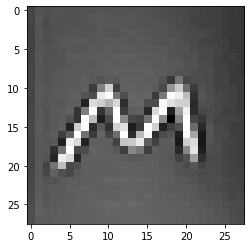

In [9]:
show_prediction(classes, result, confidence)

# Taking it up a notch
    The image classifier works well on images with a single letter/digit in them, but in order to make it classify multiple objects from a single picture I will use the "Sliding window" and "Image Pyramid" techniques. There are libraries like 
    ImageAI which can help with these implementations, but for this one I will be using hand-made functions.
    
   ### Sliding Window:
    -In the context of computer vision (and as the name suggests), a sliding window is a rectangular region of fixed width and height that “slides” across an image.
   <img src="./sample-images/sliding_window_example.gif">
    
   ### Image Pyramid:
    -An “image pyramid” is a multi-scale representation of an image.Utilizing an image pyramid allows finding objects in images at different scales of an image. And when combined with a sliding window it can find objects in images in various locations.
   <img src="./sample-images/pyramid_example.png">


In [7]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [8]:
def pyramid(image, scale=1.5, minSize=(30, 30)):
    
    image = np.array(image)
    
    # yield the original image
    #yield image
 
    # keep looping over the pyramid
    while True:
        # compute the new dimensions of the image and resize it
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
 
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        
        # yield the next image in the pyramid
        yield image

## Loading custom image

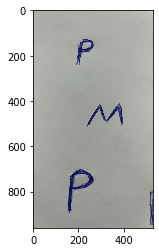

In [9]:
# load the image and define the window width and height
image = Image.open("./sample-images/PMP.jpg")

# load the window size of the sliding window that will go accross the image
(winW, winH) = (128, 128)

#Plot the image and check it's size
plt.imshow(image)

## Picking the best windows for the output

In [10]:
def most_confident_sliding_windows(model, classes, image, winW, winH):
    windows = []
    scale_custom = 1.5
    
    # loop over the image pyramid
    for resized in pyramid(image, scale=scale_custom): 
        # loop over the sliding window for each layer of the pyramid
        for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
            # if the window does not meet the desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue
            
            emnistImg = np.array(image_to_emnist(Image.fromarray(window, 'RGB'))).reshape(1,28,28,1)
            label, confidence = run_prediction(emnistImg, model)
    
            if confidence > 0.40:
                windows.append({'x': x, 'x2' : x + winH,
                                'y': y, 'y2' : y + winW,
                                'label': classes[label], 
                                'conf': confidence, 'size': window})
     

            clone = resized.copy()
            cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
            cv2.imshow("Window", clone)
            cv2.waitKey(1)
            time.sleep(0.025)
            
    cv2.destroyAllWindows()
    return windows

## Bringing the number of total windows down by removing some of the overlapping windows

In [11]:
def remove_overlapping_windows(windows):
    overlapRate = 1.8
    
    keepWindow = [True] * len(windows)

    for i in range(len(windows)):
        for j in range(i+1, len(windows)):
            # If the images are of the same size - choose the one with larger confidence
            if windows[i]['size'].shape[0] == windows[j]['size'].shape[0]:
                # Check for overlapping between the pictures
                if abs(windows[i]['x'] - windows[j]['x']) < windows[i]['size'].shape[0] / overlapRate and abs(windows[i]['y'] - windows[j]['y']) < windows[i]['size'].shape[0] / overlapRate:
                    if windows[i]['conf'] > windows[j]['conf']:
                        keepWindow[j] = False
                    else:
                        keepWindow[i] = False
            # IF the images are smaller than the current one, prefer the larger
            else:
                # Check for overlapping between the pictures
                if abs(windows[i]['x'] - windows[j]['x']) < windows[i]['size'].shape[0] / overlapRate and abs(windows[i]['y'] - windows[j]['y']) < windows[i]['size'].shape[0] / overlapRate:
                    keepWindow[j] = False

    #Return the best picture regions that do not overlap 
    result = []                
    for i in range(len(windows)):
        if keepWindow[i]:
            result.append(windows[i])

    return result

In [12]:
def sort_result(windows):
        result = []          
        
        for win in windows:
            result.append(win['label'])

        print(sorted(result))

In [13]:
def show_windows(windows):
    
    for win in windows:
        display(Image.fromarray(win['size'], 'RGB'))
        print('Predicted:', win['label'], 'Confidence:', win['conf'], 'Window size:', win['size'].shape[0])
        print()

# Testing the classifier on image drawn in paint.net

In [21]:
imagePath = './sample-images/deepl.png'
img = Image.open(imagePath)

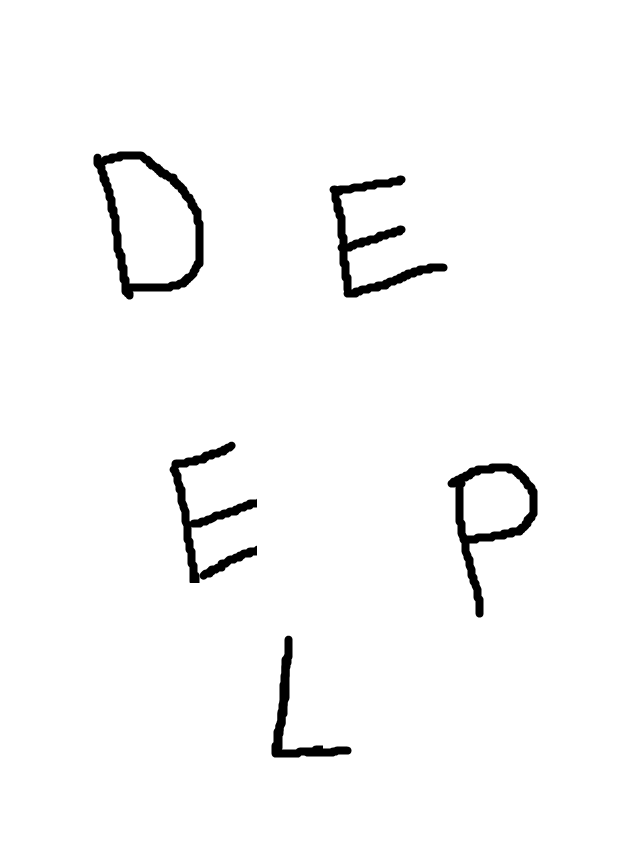

['D', 'E', 'E', 'L', 'P']

Best windows:


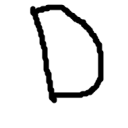

Predicted: D Confidence: 0.99805546 Window size: 128



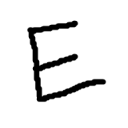

Predicted: E Confidence: 0.9995797 Window size: 128



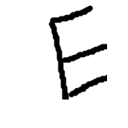

Predicted: E Confidence: 0.9544357 Window size: 128



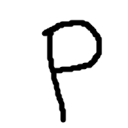

Predicted: P Confidence: 0.9996909 Window size: 128



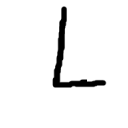

Predicted: L Confidence: 0.92904365 Window size: 128



In [22]:
most_confident_windows = most_confident_sliding_windows(model, classes, img, winW, winH)
filteredWindows = remove_overlapping_windows(most_confident_windows)

display(img)
sort_result(filteredWindows)
print()

print('Best windows:')
show_windows(filteredWindows)

## Results
    - It is working almost flawlessly on image done in graphics editor. The classifier managed to predict 5 out of 5 letters. But there are some cases where it cannot classify every single symbol perfectly. That is because the way I have implemented the solution to this problem gives way too many detected objects(letters/digits in this case). This can be further improved by enhancing the "pyramid", "most_confident_sliding_windows", "remove_overlapping_windows" functions.
### Example on another image:

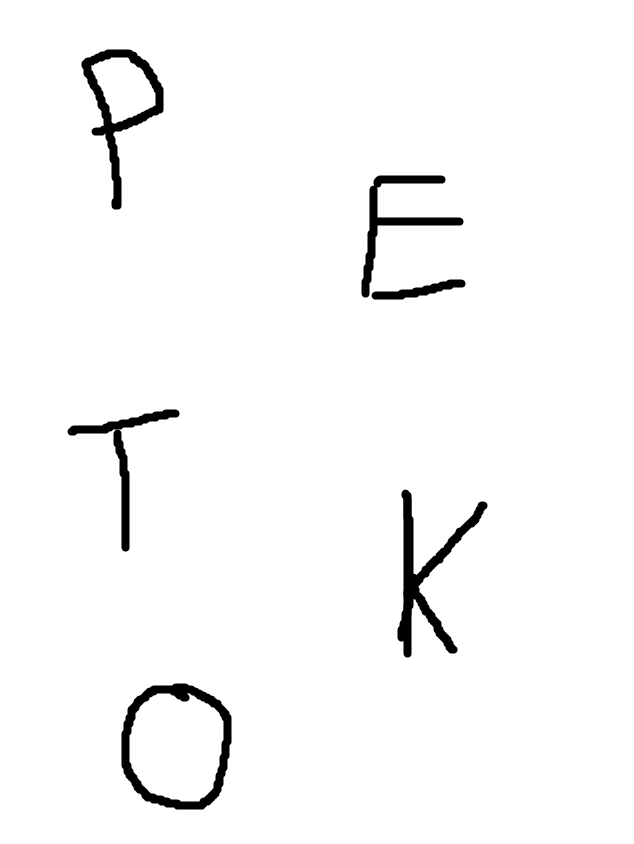

['E', 'E', 'K', 'K', 'P', 'T', 'T']

Best windows:


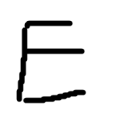

Predicted: E Confidence: 0.9999156 Window size: 128



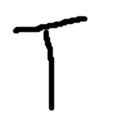

Predicted: T Confidence: 0.9963092 Window size: 128



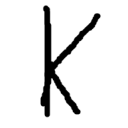

Predicted: K Confidence: 0.9999764 Window size: 128



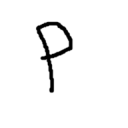

Predicted: P Confidence: 0.9732736 Window size: 128



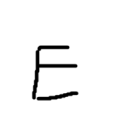

Predicted: E Confidence: 0.99930334 Window size: 128



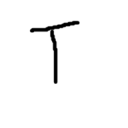

Predicted: T Confidence: 0.98611593 Window size: 128



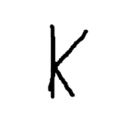

Predicted: K Confidence: 0.9925718 Window size: 128



In [23]:
imagePath = './sample-images/petko.png'
img = Image.open(imagePath)

most_confident_windows = most_confident_sliding_windows(model, classes, img, winW, winH)
filteredWindows = remove_overlapping_windows(most_confident_windows)

display(img)
sort_result(filteredWindows)
print()

print('Best windows:')
show_windows(filteredWindows)

# Taking it further by feeding it an image of letters written and taken by me

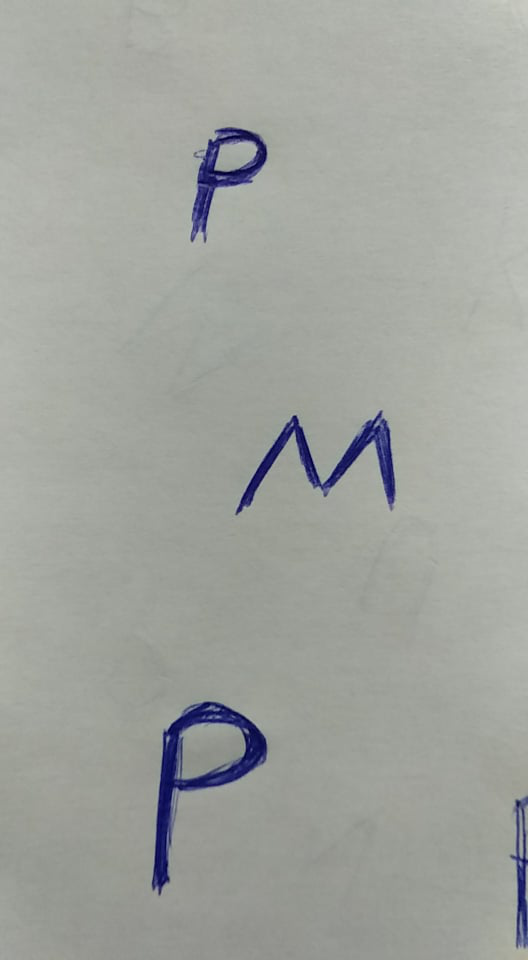

['M', 'M', 'P', 'P']

Final Results:


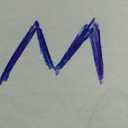

Predicted: M Confidence: 0.9964993 Window size: 128



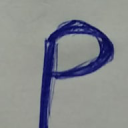

Predicted: P Confidence: 0.95235676 Window size: 128



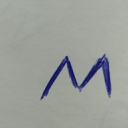

Predicted: M Confidence: 0.9714606 Window size: 128



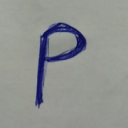

Predicted: P Confidence: 0.8614924 Window size: 128



In [28]:
imagePath = './sample-images/PMP.jpg'
img = Image.open(imagePath)

most_confident_windows = most_confident_sliding_windows(model, classes, img, winW, winH)
filteredWindows = remove_overlapping_windows(most_confident_windows)

display(img)
sort_result(filteredWindows)
print()

print('Final Results:')
show_windows(filteredWindows)

## Result:
    - As can be seen above, the classifier predicted 4 Letters, all correct but it added one extra because of the many predictions it gets during the sliding_window. 

## In retrospect:
    - Initially I decided to go with some kind of problem which would require RNN solution like extracting one person's voice amongst many. But quickly after that I went on and started working on this type of Letter/Digits classifier.
    - I started off with choosing the dataset and decided to use the extension of MNIST which is called EMNIST.
    - I came up with the model architecture. It took the model averagely 5 minutes to train with no augmentation. With augmentation it takes around 23 minutes.(Letters-and-Digits-Model.ipynb)
    - When the time came to feed the classifier some pictures I had to make an image pre-processor so it would fit the classifier's input accordingly.(Image-Converter.ipynb)
    - Lastly, I saw that the classifier started doing well with single, centered letters/digits and taking it a step further would mean to extend its range of prediction and classify multiple objects from a single picture. This explained in details in the current notebook.
    